# WNS Analytics Wizard

Importing libraries

In [26]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Creating useful functions

In [2]:
def evaluate(actual, predicted, predicted_probability):
    print("Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(actual, predicted)))
    print("")
    print("For Class 1")
    print("f1 Score :", f1_score(actual, predicted))
    print("Precision Score :",precision_score(actual, predicted))
    print("Recall Score :",recall_score(actual, predicted))
    print("")
    print("For Class 0")
    print("f1 Score :", f1_score(1-np.array(actual), 1-np.array(predicted)))
    print("Precision Score :",precision_score(1-np.array(actual), 1-np.array(predicted)))
    print("Recall Score :",recall_score(1-np.array(actual), 1-np.array(predicted)))
    print("")
    print("AUROC :",  roc_auc_score(actual, predicted_probability[:,1]))

In [3]:
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    _ = plt.title('ROC')
    _ = plt.plot(fpr, tpr, 'b', alpha=0.2)
#     _ = plt.plot([0, 1], [0, 1],'r--', alpha=0.2)
    _ = plt.xlim([0, 1])
    _ = plt.ylim([0, 1])
    _ = plt.ylabel('True Positive Rate')
    _ = plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def generate_submission(impression_ids, is_clicks, method_name):
    submission_frame = pd.DataFrame(is_clicks, index=impression_ids)
    submission_frame.columns = ['is_click']
    submission_frame.index.name = 'impression_id'
    print(submission_frame.head())
    submission_frame.to_csv('data/test/'+method_name+'.csv')

In [27]:
def flow(X, y, training_func, X_future, y_future_ids):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)
    
    model = training_func(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    evaluate(y_test, y_pred, y_pred_prob)
    plot_roc(y_test, y_pred)
    
    y_future_pred = model.predict(X_future)
    generate_submission(y_future_ids, y_future_pred, training_func.__name__)
    

## Data Wrangling User details

In [8]:
# Read Items
user_details = pd.read_csv('data/train/user_details.csv', index_col='user_id')
user_details.head()

,max_price,min_price,total_items,total_unique_items,total_sessions,freq_product_type,freq_category_1,freq_category_2,freq_category_3,freq_device
user_id,,,,,,,,,,
0,92160,332,42,18,11,7363,14,29,199,0
1,12595,383,8,8,3,7391,11,76,147,0
2,281536,128,165,130,37,8127,1,42,279,0
3,16640,537,8,3,1,6659,14,62,157,0
4,58252,1977,2,2,1,4426,14,3,27,0


## Feature Engineering

In [29]:
feature_cols = ['max_price', 'min_price', 'total_items', 'total_unique_items', 'total_sessions', 
                'freq_product_type', 'freq_device', 'app_code', 'os_version_int', 'is_4G','user_id']
categorical_feature = [5, 6, 7, 8, 9, 10]
os_version_map = {'old':0,'intermediate':1,'latest':2}

In [30]:
def extract_features(dataframe):
    sub_dataframe = dataframe[['user_id','app_code','os_version','is_4G']]
    sub_dataframe['os_version_int'] = sub_dataframe['os_version'].replace(os_version_map)
    merged_dataframe = pd.merge(sub_dataframe, user_details, how='left', on='user_id')
    return merged_dataframe[feature_cols].values

In [31]:
# Reading Training Data
training_df = pd.read_csv('data/train/train.csv', index_col='impression_id', parse_dates=['impression_time'])
X = extract_features(training_df)
y = training_df['is_click'].values
X[:1]

array([[2.3500e+03, 2.3500e+03, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        5.6220e+03, 0.0000e+00, 4.2200e+02, 0.0000e+00, 0.0000e+00,
        8.7862e+04]])

In [32]:
# Reading Testing Data
testing_df = pd.read_csv('data/test/test.csv', index_col='impression_id', parse_dates=['impression_time'])
X_future = extract_features(testing_df)
y_future_ids = testing_df.index.values
X_future[:1]

array([[2.3424e+04, 2.3424e+04, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.6170e+03, 0.0000e+00, 1.2700e+02, 2.0000e+00, 1.0000e+00,
        4.4754e+04]])

## Trying LightGBM

best_estimator LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2019, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
best_score 0.72625803399519
Confusion Matrix
       0   1
0  56611   8
1   2773  11

For Class 1
f1 Score : 0.00784873349982162
Precision Score : 0.5789473684210527
Recall Score : 0.003951149425287357

For Class 0
f1 Score : 0.9760264820737394
Precision Score : 0.9533039202478782
Recall Score : 0.9998587046751091

AUROC : 0.7214924945486599


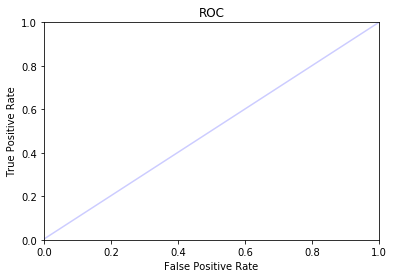

                                  is_click
impression_id                             
a9e7126a585a69a32bc7414e9d0c0ada         0
caac14a5bf2ba283db7708bb34855760         0
13f10ba306a19ce7bec2f3cae507b698         0
39c4b4dc0e9701b55a0a4f072008fb3f         0
bf5a572cca75f5fc67f4b14e58b11d70         0


In [34]:
def tunned_light_gbm_cat(X_train, y_train):
    lgb = LGBMClassifier(eval_metric = 'auc',random_state=2019)
    params = {
        'max_depth': [5, 10, 15],
        'learning_rate': [0.1, 0.5, 1.0]
    }
    lgb_grid = GridSearchCV(lgb, params, cv=10, scoring='roc_auc')
    lgb_grid.fit(X_train, y_train, categorical_feature=categorical_feature)
    print('best_estimator', lgb_grid.best_estimator_)
    print('best_score', lgb_grid.best_score_)
    return lgb_grid.best_estimator_

flow(X, y, tunned_light_gbm_cat, X_future, y_future_ids)